<!DOCTYPE html>
<html>
<body>

<h1>DICOM Pixel Deidentification:</h1>

<p>This notebook provides a hands-on demonstration of deidentifying Protected Health Information (PHI) within both DICOM image pixel data and metadata. However, the primary focus is on PHI present in the image pixels. If you're interested in metadata deidentification, please refer to the notebooks that include "Metadata" in their filenames. We’ll walk through the key steps and include code examples to guide you through the process.</p>

<h2>Environment Setup:</h2>

<ul>
    <li><strong>Google Colab (Recommended):</strong> If you are using Google Colab, the environment is generally pre-configured for many dependencies.</li>
    <li><strong>Local Setup (If not using Colab):</strong>
        <ul>
            <li><strong>Homebrew:</strong> Ensure you have Homebrew installed. (e.g., <code>/bin/bash -c "$(curl -fsSL https://raw.githubusercontent.com/Homebrew/install/HEAD/install.sh)"</code></li>
            <li><strong>Apache Spark:</strong> Install Apache Spark (e.g., <code>brew install apache-spark</code> By default OpenJDK 17 will be installed.</li>
            <li><strong>OpenJDK 17:</strong> Ensure you have Java Path configured before starting <code>spark-ocr</code> session <code>os.environ['JAVA_HOME'] = '/home/linuxbrew/.linuxbrew/Cellar/openjdk@17/17.0.14'</code></li>
        </ul>
    </li>
</ul>

<h2>Required Libraries:</h2>

<ul>
    <li><strong>Spark-OCR:</strong> This library is crucial for text detection and Optical Character Recognition (OCR) and IO operations related to DICOM images.</li>
    <li><strong>Spark-NLP-Healthcare:</strong> This library provides advanced Named Entity Recognition (NER) models specifically designed for medical text, enabling accurate PHI identification.</li>
    <li><strong>Spark-NLP: </strong>Open Source Library installed automatically with Visual NLP.</li>
</ul>

<img
  src="https://www.johnsnowlabs.com/wp-content/uploads/2023/03/visual_nlp.png"
  alt="Visual NLP Diagram from John Snow Labs"
  style="max-width: 100%; height: auto;" >
</body>
</html>

<h2>Installation Steps</h2>
<ul>
    <li>Make sure license file is present in the same directory, and <strong>license</strong> variable is populated.</li>
    <li>Set Environment Variables.</li>
    <li>Install Visual-NLP, Healthcare-NLP, Pandas and Matplotlib.</li>
    <li><strong>Restart Session!!!!<strong></li>
</ul>

In [1]:
import json 
import os 

license = ""

if license and "json" in license:
    
    with open(license, "r") as creds_in:
        creds = json.loads(creds_in.read())

        for key in creds.keys():
            os.environ[key] = creds[key]
else:
    raise Exception("License JSON File is not specified")

In [2]:
# Install Visual-NLP
!python3 -m pip install -q --upgrade spark-ocr==$OCR_VERSION --user --extra-index-url https://pypi.johnsnowlabs.com/$SPARK_OCR_SECRET

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [3]:
# Install Healthcare-NLP
!python3 -m pip install -q --upgrade spark-nlp-jsl==$JSL_VERSION --extra-index-url https://pypi.johnsnowlabs.com/$SECRET


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [4]:
!pip install -q pandas matplotlib


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip


In [ ]:
# RESTART SESSION!!!

<h2>Notebook Objectives:</h2>

<p>This notebook will illustrate the following key stages of DICOM pixel deidentification:</p>

<ul>
    <li>Loading and processing DICOM images.</li>
    <li>Detecting text within the image pixels using Spark-OCR.</li>
    <li>Performing Optical Character Recognition (OCR) to extract the detected text.</li>
    <li>Identifying PHI entities within the extracted text using Spark-NLP-Healthcare's NER models.</li>
    <li>De-Identifying the sensitive PHI regions within the pixel data.</li>
</ul>

<p>By following this notebook, you will gain practical experience in building a DICOM pixel deidentification pipeline using Visual-NLP and Healthcare-NLP.</p>

<h2>Start Visual-NLP Session with Healthcare-NLP</h2>

<h2>Configuration:</h2>

<p>To execute the code, you'll need to provide the following configuration details:</p>

<ol>
    <li><strong>License Information:</strong>
        <ul>
            <li>Specify the license for <code>Spark-OCR</code> OR <code>Spark-NLP-Healthcare</code> license from your license file.</li>
        </ul>
    </li>
    <li><strong>Library Paths:</strong>
        <ul>
            <li>Provide the folder path to the <code>spark-ocr-assembly-[version].jar</code>file or <code>spark_ocr_secret</code> from your license file.</li>
            <li>Provide the folder path to the <code>spark-nlp-jsl-[version].jar</code>file or <code>nlp_secret</code> from your license file.</li>
        </ul>
    </li>
    <li><strong>AWS Credentials (for Model Downloads):</strong>
        <ul>
            <li>Supply your AWS access key (<code>aws_access_key</code>).</li>
            <li>Supply your AWS secret key (<code>aws_secret_key</code>).</li>
            <li>Supply your AWS session token (<code>aws_session_token</code>).</li>
        </ul>
    </li>
</ol>

In [1]:
from sparkocr import start
import os
import json
import time
import shutil

license = ""

if license and "json" in license:
    
    with open(license, "r") as creds_in:
        creds = json.loads(creds_in.read())

        for key in creds.keys():
            os.environ[key] = creds[key]
else:
    raise Exception("License JSON File is not specified")

In [ ]:
extra_configurations = {
    "spark.extraListeners": "com.johnsnowlabs.license.LicenseLifeCycleManager",
}

# Set Java Path
# Not Required on Google Collab
os.environ['JAVA_HOME'] = '/home/linuxbrew/.linuxbrew/Cellar/openjdk@17/17.0.14'

spark = start(secret=os.environ["SPARK_OCR_SECRET"],
              nlp_secret=os.environ["SECRET"],
              nlp_internal=True,
              nlp_jsl=True,
              nlp_version=os.environ["PUBLIC_VERSION"],
              extra_conf=extra_configurations,
              use_gpu=False)

spark

<h2>Import Transformers and Annotators</h2>

In [3]:
import os
import sys
import time
from PIL import Image
import io

from sparknlp.annotator import *
from sparknlp.base import *
import sparknlp_jsl
from sparknlp_jsl.annotator import *

import sparkocr
from sparkocr.transformers import *
from sparkocr.utils import *
from sparkocr.enums import *

from pyspark.ml import PipelineModel, Pipeline
from sparknlp.pretrained import PretrainedPipeline
from pyspark.ml import PipelineModel, Pipeline

import pyspark.sql.functions as F

print(f"Spark NLP version: {sparknlp.version()}")
print(f"Spark NLP internal version: {sparknlp_jsl.version()}")
print(f"Spark OCR version: {sparkocr.version()}")

Spark NLP version: 5.5.2
Spark NLP internal version: 5.5.2
Spark OCR version: 5.5.1rc4


<h2>Building the DICOM Deidentification Pipeline</h2>

<p>We'll construct a pipeline designed to extract and deidentify Protected Health Information (PHI) from DICOM images. This process involves several key stages:</p>

<ol>
    <li>
        <strong>DICOM Image Processing</strong>
        <ul>
            <li>Integrate DICOM image handling, text detection, and Optical Character Recognition (OCR) stages from the Visual NLP library. This allows the pipeline to process DICOM images and extract text from pixels.</li>
        </ul>
    </li>
    <li>
        <strong>NER Detection</strong>
        <ul>
            <li>Combine Document Assembler, Sentence and NER detection stages to create ner_chunks using text from the ocr stage. </li>
        </ul>
    </li>
    <li>
        <strong>Generate Coordinates</strong>
        <ul>
            <li>With ner_chunks and positions, coordinates can be generated for Sensitive PHI, which is then fed into the final Dicom Stages.</li>
        </ul>
    </li>
    <li>
        <strong>Partial Pipeline Construction (for Visualization)</strong>
        <ul>
            <li>Note: This pipeline is deliberately incomplete. We've omitted the final redaction or replacement stages. This is to enable visualization of the intermediate results (detected text, recognized entities) which would be obscured if the final deidentification steps were executed.</li>
        </ul>
    </li>
</ol>
<p>By constructing this partial pipeline, we can effectively inspect the accuracy of the text detection, OCR, and NER stages before implementing the final dicom stages.</p>

In [ ]:
dicom_to_image = DicomToImageV3() \
    .setInputCols(["content"]) \
    .setOutputCol("image_raw") \
    .setKeepInput(True)

text_detector = ImageTextDetector.pretrained("image_text_detector_mem_opt", "en", "clinical/ocr") \
    .setInputCol("image_raw") \
    .setOutputCol("text_regions") \
    .setScoreThreshold(0.7) \
    .setWithRefiner(True) \
    .setTextThreshold(0.4) \
    .setLinkThreshold(0.5) \
    .setSizeThreshold(1) \
    .setUseGPU(False) \
    .setWidth(0) \
    .setHeight(0)

ocr_text = ImageToTextV2.pretrained("ocr_large_printed_v2_opt", "en", "clinical/ocr") \
    .setRegionsColumn("text_regions") \
    .setInputCols(["image_raw"]) \
    .setOutputCol("text") \
    .setOutputFormat(OcrOutputFormat.TEXT_WITH_POSITIONS) \
    .setGroupImages(False) \
    .setKeepInput(True) \
    .setUseGPU(False) \
    .setUseCaching(True) \
    .setBatchSize(4) 

document_assembler = DocumentAssembler() \
    .setInputCol("text") \
    .setOutputCol("document") \
    .setCleanupMode("disabled")

sentence_detector = SentenceDetectorDLModel.pretrained("sentence_detector_dl","xx")\
    .setInputCols(["document"])\
    .setOutputCol("sentence")

tokenizer = Tokenizer()\
    .setInputCols(["sentence"])\
    .setOutputCol("token")

embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
    .setInputCols("sentence", "token")\
    .setOutputCol("embeddings")

glove_embeddings = WordEmbeddingsModel.pretrained('glove_100d') \
      .setInputCols(['sentence', 'token']) \
      .setOutputCol('embeddings_glove')

clinical_ner_glove = MedicalNerModel.pretrained("ner_deid_generic_glove", "en", "clinical/models") \
      .setInputCols(["sentence", "token", "embeddings_glove"]) \
      .setOutputCol("ner_glove")

ner_converter_glove = NerConverterInternalModel() \
        .setInputCols(["sentence", "token", "ner_glove"]) \
        .setOutputCol("ner_chunk_glove") \
        .setThreshold(0.7) \
        .setWhiteList(['ID', 'NAME', 'AGE', 'SEX', 'PERSON', 'DATE', 'DOCTOR', 'PATIENT'])

clinical_ner_sub_glove = MedicalNerModel.pretrained("ner_deid_subentity_glove", "en", "clinical/models") \
      .setInputCols(["sentence", "token", "embeddings_glove"]) \
      .setOutputCol("ner_sub_glove")

ner_converter_sub_glove = NerConverterInternalModel() \
        .setInputCols(["sentence", "token", "ner_sub_glove"]) \
        .setOutputCol("ner_chunk_sub_glove") \
        .setThreshold(0.7) \
        .setWhiteList(['ID', 'NAME', 'AGE', 'SEX', 'PERSON', 'DATE', 'DOCTOR', 'PATIENT'])

clinical_ner_multi = MedicalNerModel.pretrained("ner_deid_name_multilingual_clinical_langtest", "xx", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("ner_multi")

ner_converter_multi = NerConverterInternalModel() \
        .setInputCols(["sentence", "token", "ner_multi"]) \
        .setOutputCol("ner_chunk_multi") \
        .setThreshold(0.7) \
        .setWhiteList(['ID', 'NAME', 'AGE', 'SEX', 'PERSON', 'DATE', 'DOCTOR', 'PATIENT'])

clinical_ner_large = MedicalNerModel.pretrained("ner_deid_large", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("ner_deid_large")

ner_converter_large = NerConverterInternalModel() \
        .setInputCols(["sentence", "token", "ner_deid_large"]) \
        .setOutputCol("ner_chunk_large") \
        .setThreshold(0.7) \
        .setWhiteList(['ID', 'NAME', 'AGE', 'PERSON', 'DATE', 'DOCTOR', 'PATIENT'])

chunk_merger = ChunkMergeApproach()\
    .setInputCols('ner_chunk_glove', "ner_chunk_sub_glove", "ner_chunk_multi", "ner_chunk_large")\
    .setOutputCol('merged_ner_chunk') \
    .setMergeOverlapping(True)

position_finder = PositionFinder() \
    .setInputCols("merged_ner_chunk") \
    .setOutputCol("coordinates") \
    .setPageMatrixCol("positions")

stages = [
    dicom_to_image,
    text_detector,
    ocr_text,
    document_assembler,
    sentence_detector,
    tokenizer,
    embeddings,
    glove_embeddings,
    clinical_ner_glove,
    ner_converter_glove,
    clinical_ner_sub_glove,
    ner_converter_sub_glove,
    clinical_ner_multi,
    ner_converter_multi,
    clinical_ner_large,
    ner_converter_large,
    chunk_merger,
    position_finder
]

dicom_pipe = Pipeline(stages=stages)

In [5]:
stages

[DicomToImageV3_c3996317d911,
 ImageTextDetectorCraft_1be80ee1b9a0,
 ImageToTextV2_5c05f20c086d,
 DocumentAssembler_2911d7f52535,
 SentenceDetectorDLModel_8aaebf7e098e,
 Tokenizer_df5e49de620c,
 WORD_EMBEDDINGS_MODEL_9004b1d00302,
 WORD_EMBEDDINGS_MODEL_48cffc8b9a76,
 MedicalNerModel_1c278433019e,
 NerConverterInternalModel_ceb23228a8d0,
 MedicalNerModel_af9c2512011c,
 NerConverterInternalModel_c9d3b54793cc,
 MedicalNerModel_2cb37763b81b,
 NerConverterInternalModel_8941f4159465,
 MedicalNerModel_15975bb9777e,
 NerConverterInternalModel_6c5b7aef5f80,
 ChunkMergeApproach_dc7077cf5345,
 PositionFinder_d8aa3b413168]

<h3>Load a Single Dicom File and Extract Results</h3>

13:32:00, INFO generated new fontManager


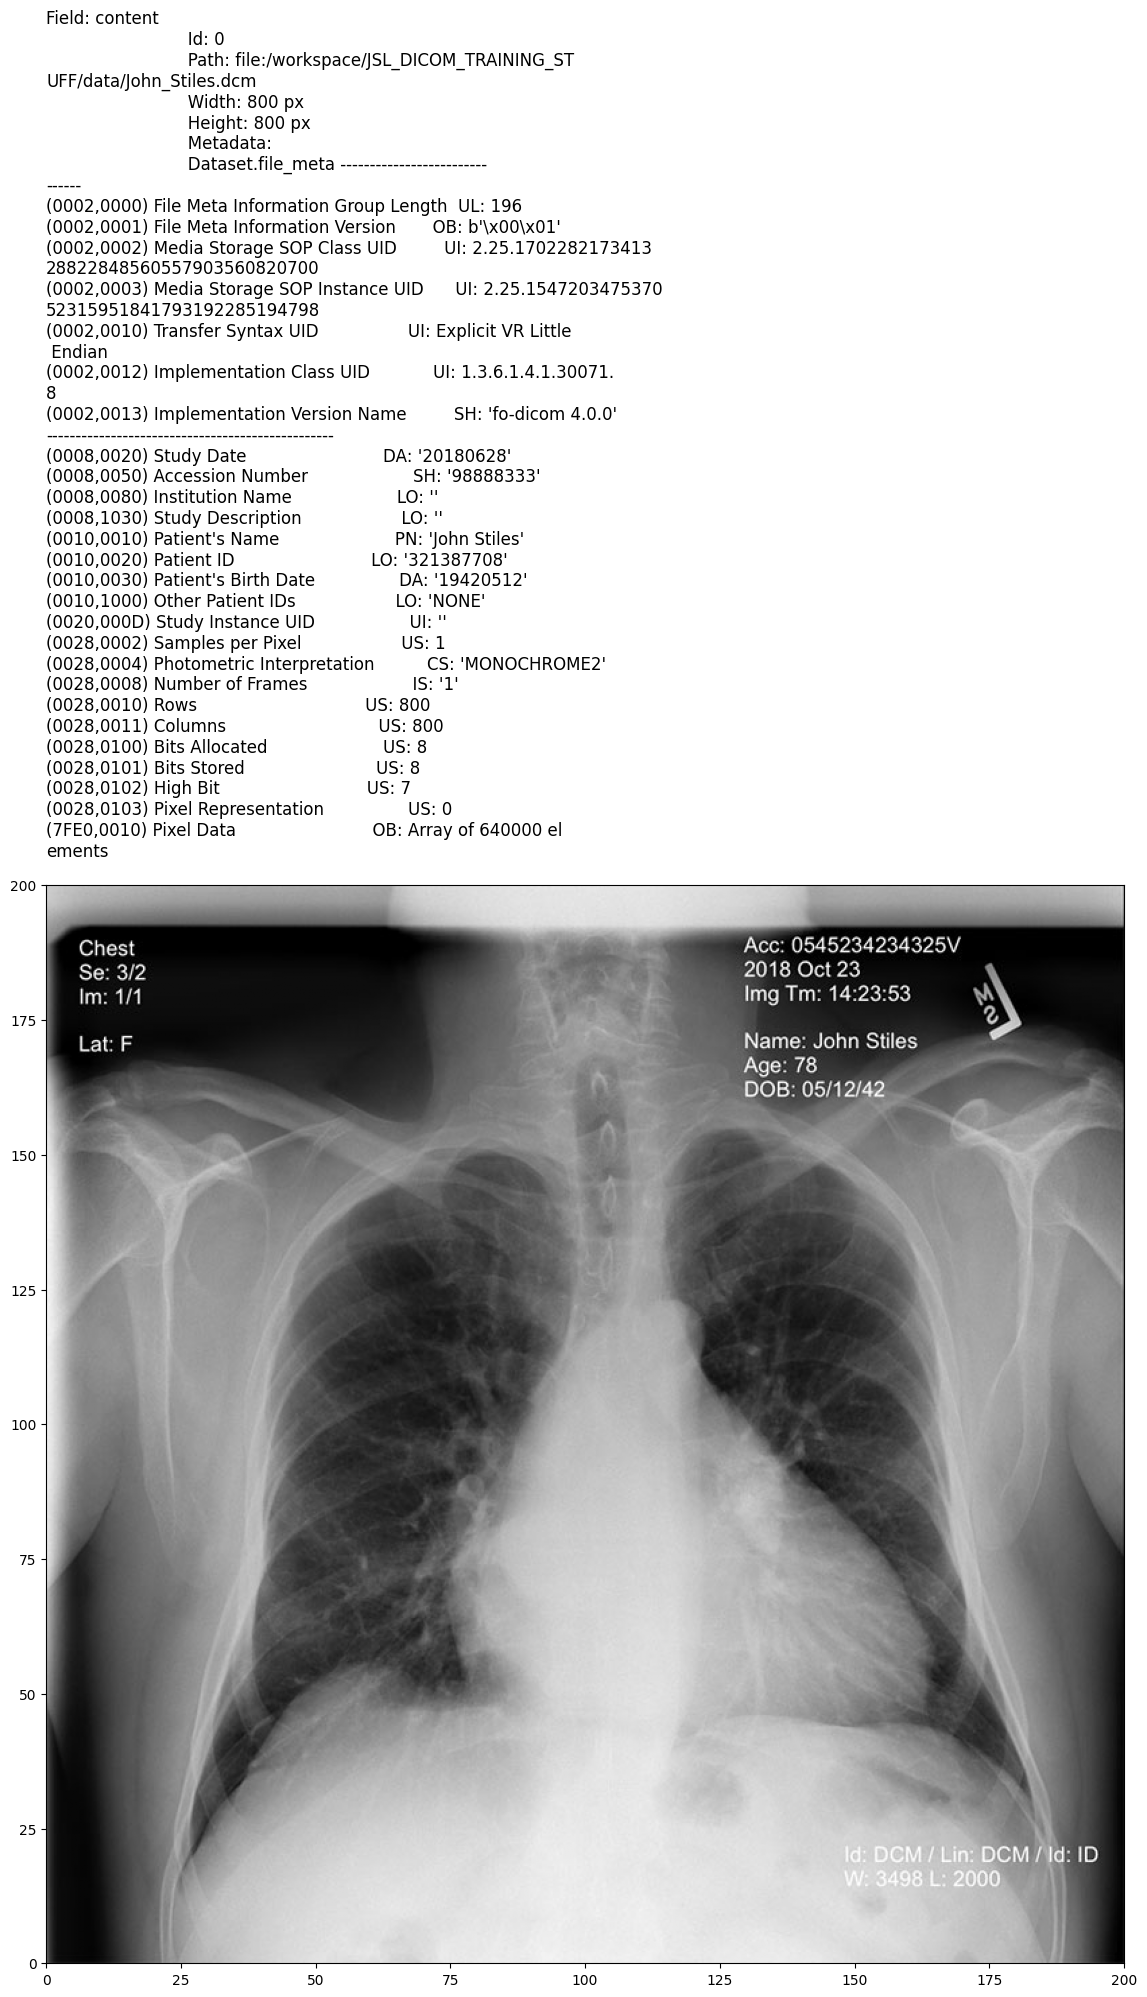

In [6]:
df = spark.read.format("binaryFile").load("./data/John_Stiles.dcm")

display_dicom(df, "content")

In [7]:
result = dicom_pipe.fit(df).transform(df).cache()

result.columns

/root/.local/lib/python3.11/site-packages/pyspark/sql/dataframe.py:168: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(
25/04/08 13:32:15 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


['image_raw',
 'pagenum',
 'path',
 'modificationTime',
 'length',
 'content',
 'text_regions',
 'text',
 'confidence',
 'positions',
 'exception',
 'document',
 'sentence',
 'token',
 'embeddings',
 'embeddings_glove',
 'ner_glove',
 'ner_chunk_glove',
 'ner_sub_glove',
 'ner_chunk_sub_glove',
 'ner_multi',
 'ner_chunk_multi',
 'ner_deid_large',
 'ner_chunk_large',
 'merged_ner_chunk',
 'coordinates']

<h2>Visualization of Detected Text Regions</h2>

In [8]:
# View the detected regions
result.select(F.explode("text_regions").alias("detected_regions")).show(50, False)

25/04/08 13:32:20 WARN DAGScheduler: Broadcasting large task binary with size 1911.2 KiB
13:32:23, INFO Run DicomToImageV3                                   (0 + 1) / 1]
13:32:24, INFO DicomToImageV3: Number of frames: 1


+----------------------------------------------------------------------------+
|detected_regions                                                            |
+----------------------------------------------------------------------------+
|{0, 0, 597.0, 44.0, 16.0, 166.0, 0.99607843, 0, 90.0, true}                 |
|{0, 0, 46.0, 47.0, 14.0, 44.0, 0.99215686, 0, 90.0, true}                   |
|{0, 0, 561.0, 63.0, 14.0, 90.0, 0.99607843, 0, 90.0, true}                  |
|{0, 0, 48.0, 65.0, 18.0, 56.0, 0.9019608, 0, 90.0, true}                    |
|{0, 0, 579.0, 81.0, 18.0, 130.0, 0.9529412, 0, 90.0, true}                  |
|{0, 0, 699.0, 89.0, 34.0, 22.0, 0.90588236, 0, 90.0, true}                  |
|{0, 0, 49.0, 83.0, 14.0, 50.0, 0.81960785, 0, 90.0, true}                   |
|{0, 0, 582.0, 115.0, 18.0, 136.0, 0.99215686, 0, 90.0, true}                |
|{0, 0, 43.0, 118.0, 16.0, 46.0, 0.89411765, 0, 90.0, true}                  |
|{0, 0, 546.0, 137.0, 18.0, 60.0, 0.91764706, 0, 90.

25/04/08 13:32:51 WARN DAGScheduler: Broadcasting large task binary with size 1924.2 KiB



    Image #0:
    Origin: file:/workspace/JSL_DICOM_TRAINING_STUFF/data/John_Stiles.dcm
    Resolution: 0 dpi
    Width: 800 px
    Height: 800 px
    Mode: 10
    Number of channels: 1


25/04/08 13:32:55 WARN DAGScheduler: Broadcasting large task binary with size 1926.3 KiB


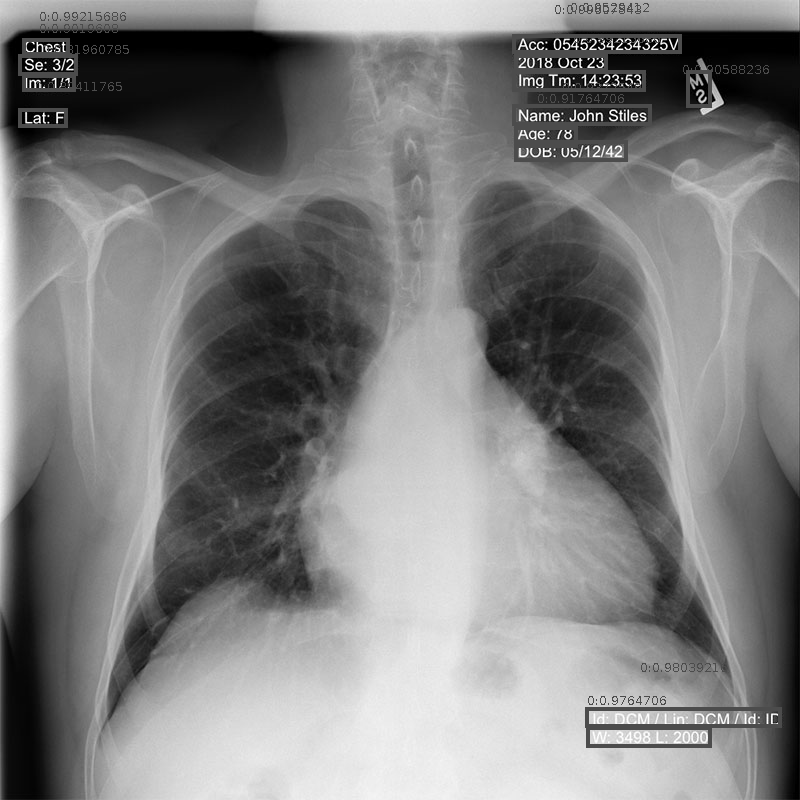

In [9]:
draw = ImageDrawRegions() \
  .setInputCol("image_raw") \
  .setInputRegionsCol("text_regions") \
  .setOutputCol("image_with_regions") \
  .setRectColor(sparkocr.enums.Color.red)

display_images(draw.transform(result), "image_with_regions")

<h2>View NER Results</h2>

In [10]:
result.select(F.explode(F.arrays_zip(result.merged_ner_chunk.result, result.merged_ner_chunk.metadata)).alias("cols")) \
                      .select(F.expr("cols['0']").alias("ner_chunk"),
                              F.expr("cols['1']['confidence']").alias("confidence"),
                              F.expr("cols['1']['entity']").alias("chunk_class")).show(truncate=False)

+--------------+----------+-----------+
|ner_chunk     |confidence|chunk_class|
+--------------+----------+-----------+
|0545234234325V|0.9984    |ID         |
|2018          |0.9779    |DATE       |
|OCT 23        |0.8864    |DATE       |
|14:23:53      |0.9579    |ID         |
|JOHN STILES   |0.97755   |NAME       |
|78            |0.984     |AGE        |
|05/12/42      |1.0       |DATE       |
|DCM           |0.9985    |NAME       |
|LIN           |0.9999    |NAME       |
+--------------+----------+-----------+



25/04/08 13:33:00 WARN DAGScheduler: Broadcasting large task binary with size 1925.7 KiB


<h2>Deidentify the Pixels Using Coordinates</h2>


    Image #0:
    Origin: file:/workspace/JSL_DICOM_TRAINING_STUFF/data/John_Stiles.dcm
    Resolution: 0 dpi
    Width: 800 px
    Height: 800 px
    Mode: 10
    Number of channels: 1


25/04/08 13:33:05 WARN DAGScheduler: Broadcasting large task binary with size 1926.3 KiB


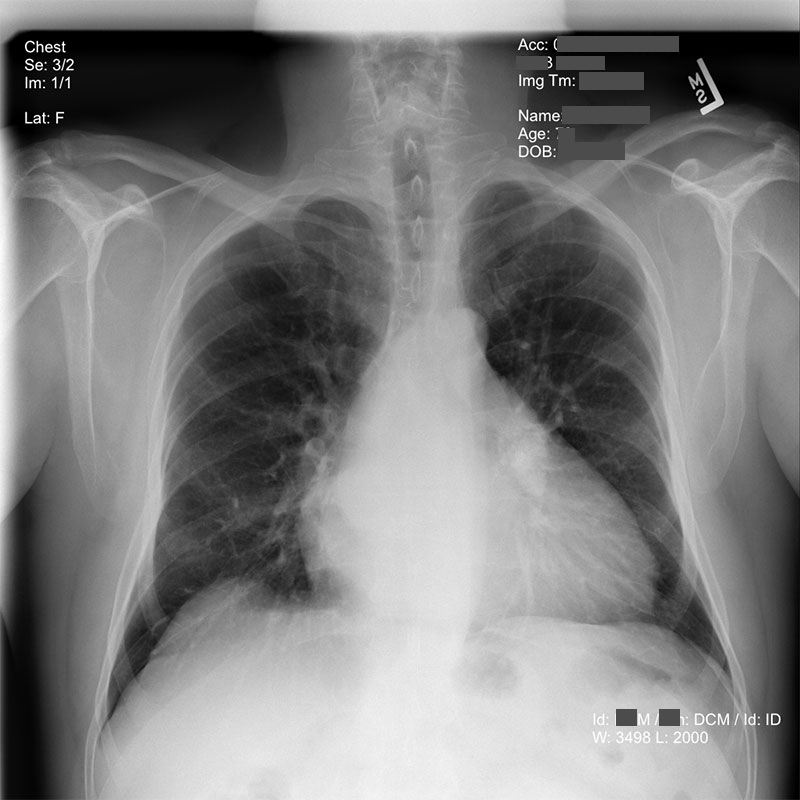

In [11]:
draw = ImageDrawRegions() \
  .setInputCol("image_raw") \
  .setInputRegionsCol("coordinates") \
  .setRectColor(Color.red) \
  .setOutputCol("image_with_regions") \
  .setFilledRect(True)

display_images(draw.transform(result), "image_with_regions")

<h2>Complete DICOM PHI Deidentification Pipeline Construction</h2>

<ol>
    <li>
        <strong>Final Deidentification Stages:</strong>
        <ul>
            <li>To complete the pipeline, we add two critical stages: <code>DicomDrawRegions</code> and <code>DicomMetadataDeidentifier</code>.</li>
            <li><strong><code>DicomDrawRegions</code>:</strong> This stage performs pixel-level redaction by drawing regions over identified PHI. Importantly, this stage aggregates and consolidates results, effectively removing intermediate result columns from previous stages.</li>
            <li><strong><code>DicomMetadataDeidentifier</code>:</strong> This stage ensures comprehensive deidentification by removing or modifying sensitive information present in the DICOM metadata tags.</li>
        </ul>
    </li>
</ol>

<p>By including these final stages, we construct a complete pipeline capable of both identifying and removing PHI from DICOM image pixel data and metadata, ensuring thorough deidentification.</p>

In [12]:
draw_regions = DicomDrawRegions() \
    .setInputCol("content") \
    .setInputRegionsCol("coordinates") \
    .setOutputCol("dicom_cleaned") \
    .setAggCols(["path"]) \
    .setKeepInput(True)

dicom_deidentifier = DicomMetadataDeidentifier() \
    .setInputCols(["dicom_cleaned"]) \
    .setOutputCol("dicom_meta_cleaned")\
    .setKeepInput(True)

full_stages = stages.copy()

full_stages.append(draw_regions)
full_stages.append(dicom_deidentifier)

dicom_full_pipe = Pipeline(stages=full_stages)

In [13]:
full_stages

[DicomToImageV3_c3996317d911,
 ImageTextDetectorCraft_1be80ee1b9a0,
 ImageToTextV2_5c05f20c086d,
 DocumentAssembler_2911d7f52535,
 SentenceDetectorDLModel_8aaebf7e098e,
 Tokenizer_df5e49de620c,
 WORD_EMBEDDINGS_MODEL_9004b1d00302,
 WORD_EMBEDDINGS_MODEL_48cffc8b9a76,
 MedicalNerModel_1c278433019e,
 NerConverterInternalModel_ceb23228a8d0,
 MedicalNerModel_af9c2512011c,
 NerConverterInternalModel_c9d3b54793cc,
 MedicalNerModel_2cb37763b81b,
 NerConverterInternalModel_8941f4159465,
 MedicalNerModel_15975bb9777e,
 NerConverterInternalModel_6c5b7aef5f80,
 ChunkMergeApproach_dc7077cf5345,
 PositionFinder_d8aa3b413168,
 DicomDrawRegions_b7607179c055,
 DicomMetadataDeidentifier_18976545d76d]

<h2>Example 1: Deidentifying David Douglas's DICOM Image</h2>

<p><strong>Input DICOM File Path:</strong> <code>./data/David_Douglas.dcm</code></p>

<p><strong>Number of Frames in Input:</strong> 1</p>

<p><strong>Output Deidentified DICOM File Path:</strong> <code>./data/result/david_douglas/</code></p>

In [14]:
df = spark.read.format("binaryFile").load("./data/David_Douglas.dcm")

dicom_full_pipe.fit(df).transform(df).write \
  .format("binaryFormat") \
  .option("type", "dicom") \
  .option("field", "dicom_meta_cleaned") \
  .option("nameField", "fileName") \
  .option("extension", "dcm") \
  .option("prefix", "de-id-") \
  .mode("overwrite") \
  .save("./data/result/david_douglas/")

25/04/08 13:33:16 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
13:33:17, INFO Run DicomToImageV3
13:33:17, INFO DicomToImageV3: Number of frames: 1
25/04/08 13:33:50 WARN DAGScheduler: Broadcasting large task binary with size 1295.6 KiB
13:33:51, INFO DicomDrawRegions: file:/workspace/JSL_DICOM_TRAINING_STUFF/data/David_Douglas.dcm Origin size: 7535058
13:33:51, WARNING DicomDrawRegions: file:/workspace/JSL_DICOM_TRAINING_STUFF/data/David_Douglas.dcm Dicom does not contain NumberOfFrames Tag Assuming value to be 1.
13:33:51, INFO DicomDrawRegions: file:/workspace/JSL_DICOM_TRAINING_STUFF/data/David_Douglas.dcm Photometric Interpretation: MONOCHROME1
13:33:51, INFO DicomDrawRegions: file:/workspace/JSL_DICOM_TRAINING_STUFF/data/David_Douglas.dcm Transfer Syntax: 1.2.840.10008.1.2
13:33:51, INFO DicomDrawRegions: file:/workspace/JSL_DICOM_TRAINING_STUFF/data/David_Douglas.dcm Pixel Representation: 0
13:33:51, INFO DicomDrawRegions: file:/workspace/JSL_DICOM_TRAININ

/usr/local/lib/python3.11/dist-packages/pydicom/valuerep.py:440: UserWarning: The value length (44) exceeds the maximum length of 16 allowed for VR SH.
  warn_and_log(msg)


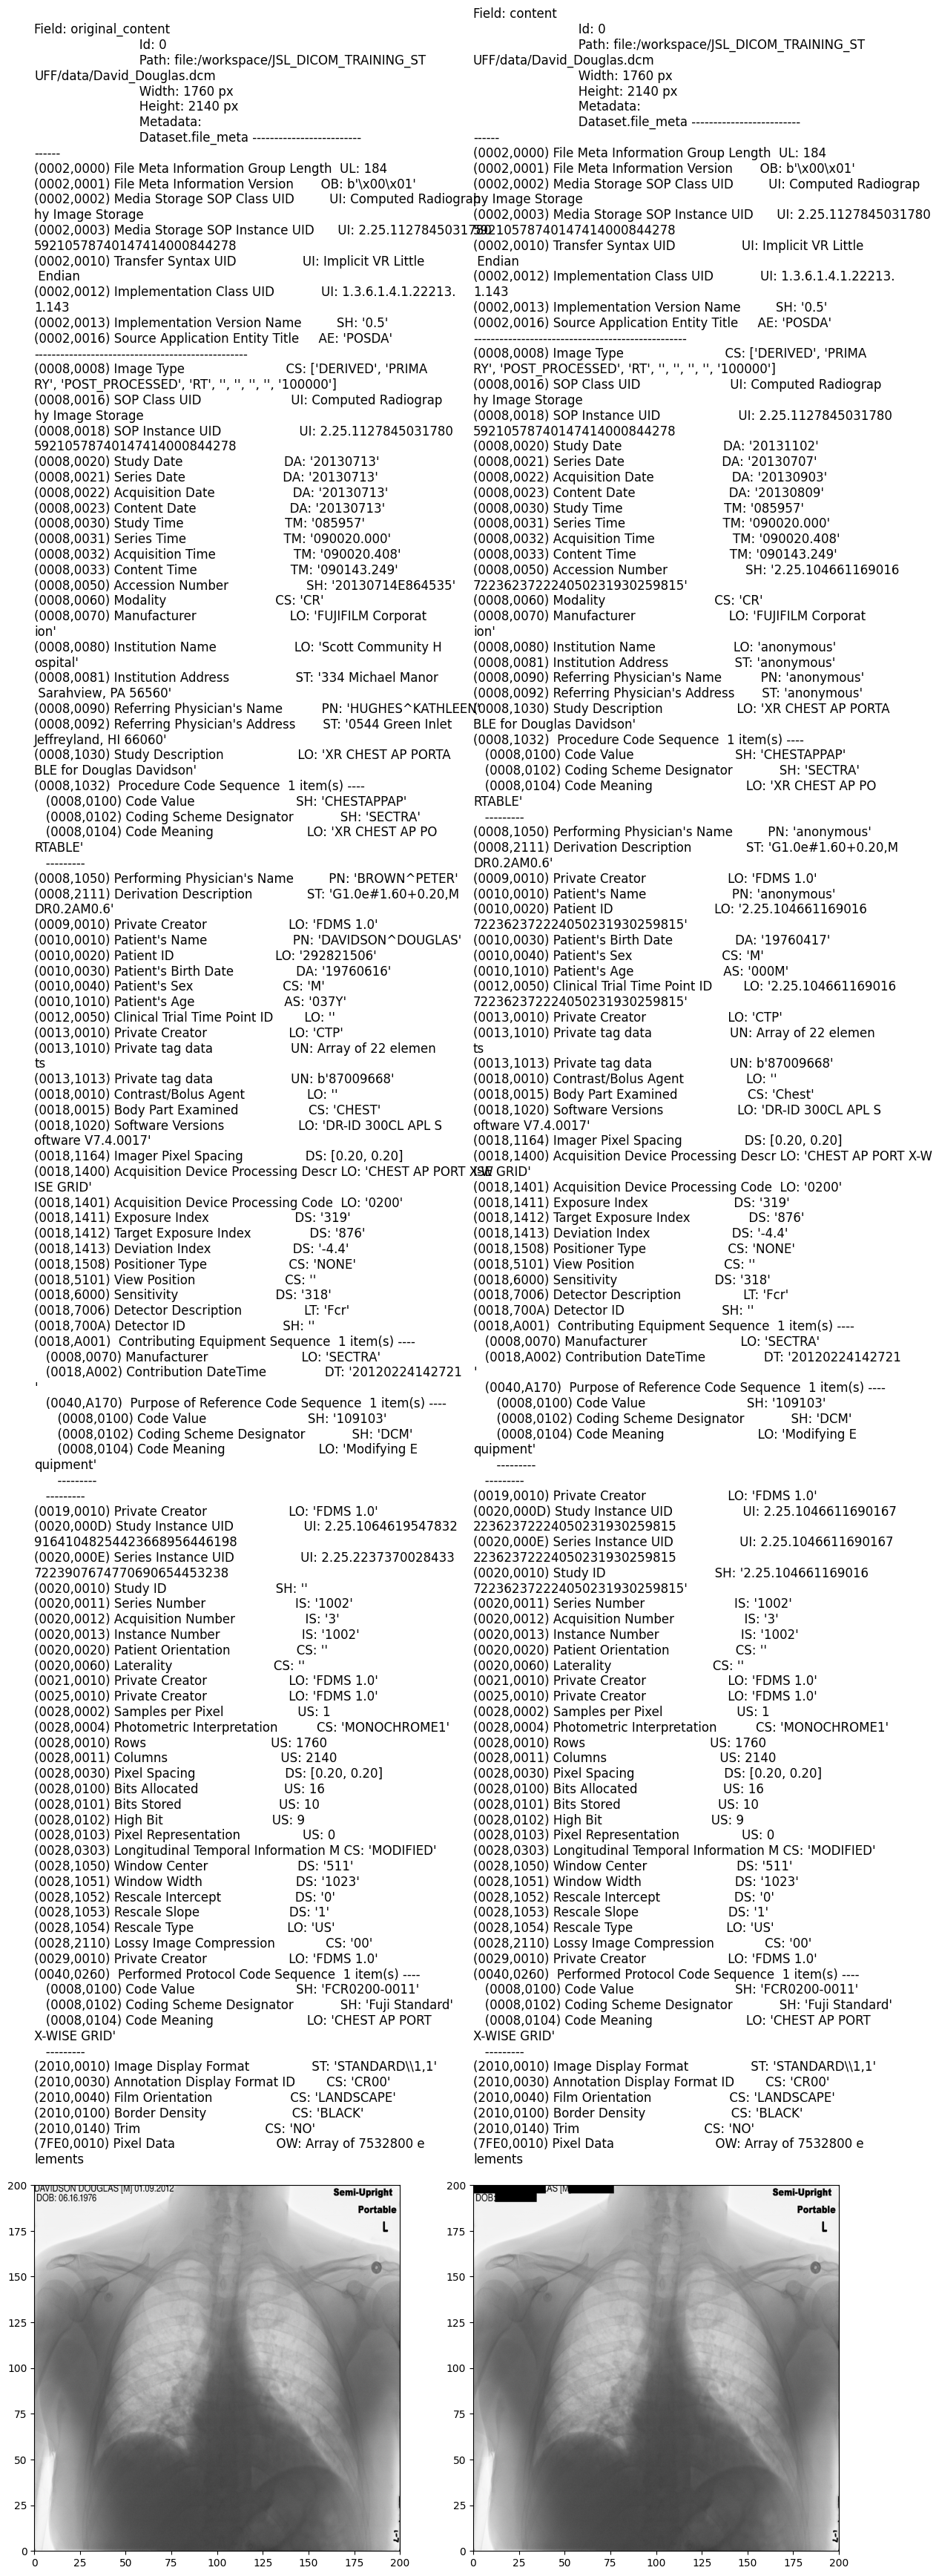

In [15]:
df = spark.read.format("binaryFile").load("./data/result/david_douglas/*.dcm").select("content")

df_orig = spark.read.format("binaryFile").load("./data/David_Douglas.dcm").withColumnRenamed("content","original_content")

display_dicom(df.join(df_orig), "original_content,content")

<h2>Example 2: Deidentifying Martin Chad Douglas's DICOM Image</h2>

<p><strong>Input DICOM File Path:</strong> <code>./data/Martin_Chad.dcm</code></p>

<p><strong>Number of Frames in Input:</strong> 1</p>

<p><strong>Output Deidentified DICOM File Path:</strong> <code>./data/result/martin_chad/</code></p>

In [16]:
df = spark.read.format("binaryFile").load("./data/Martin_Chad.dcm")

dicom_full_pipe.fit(df).transform(df).write \
  .format("binaryFormat") \
  .option("type", "dicom") \
  .option("field", "dicom_meta_cleaned") \
  .option("nameField", "fileName") \
  .option("extension", "dcm") \
  .option("prefix", "de-id-") \
  .mode("overwrite") \
  .save("./data/result/martin_chad/")

25/04/08 13:33:57 WARN SparkContext: The path /root/.local/lib/python3.11/site-packages/sparkocr/resources/ocr/dicom/first_names.all.txt has been added already. Overwriting of added paths is not supported in the current version.
25/04/08 13:33:57 WARN SparkContext: The path /root/.local/lib/python3.11/site-packages/sparkocr/resources/ocr/dicom/last_names.all.txt has been added already. Overwriting of added paths is not supported in the current version.
25/04/08 13:33:58 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
13:33:58, INFO Run DicomToImageV3
13:33:58, INFO DicomToImageV3: Number of frames: 1
25/04/08 13:34:31 WARN DAGScheduler: Broadcasting large task binary with size 1295.6 KiB
13:34:31, INFO DicomDrawRegions: file:/workspace/JSL_DICOM_TRAINING_STUFF/data/Martin_Chad.dcm Origin size: 8179102
13:34:31, WARNING DicomDrawRegions: file:/workspace/JSL_DICOM_TRAINING_STUFF/data/Martin_Chad.dcm Dicom does not contain NumberOfFrames Tag Assuming value to be 1.
13:

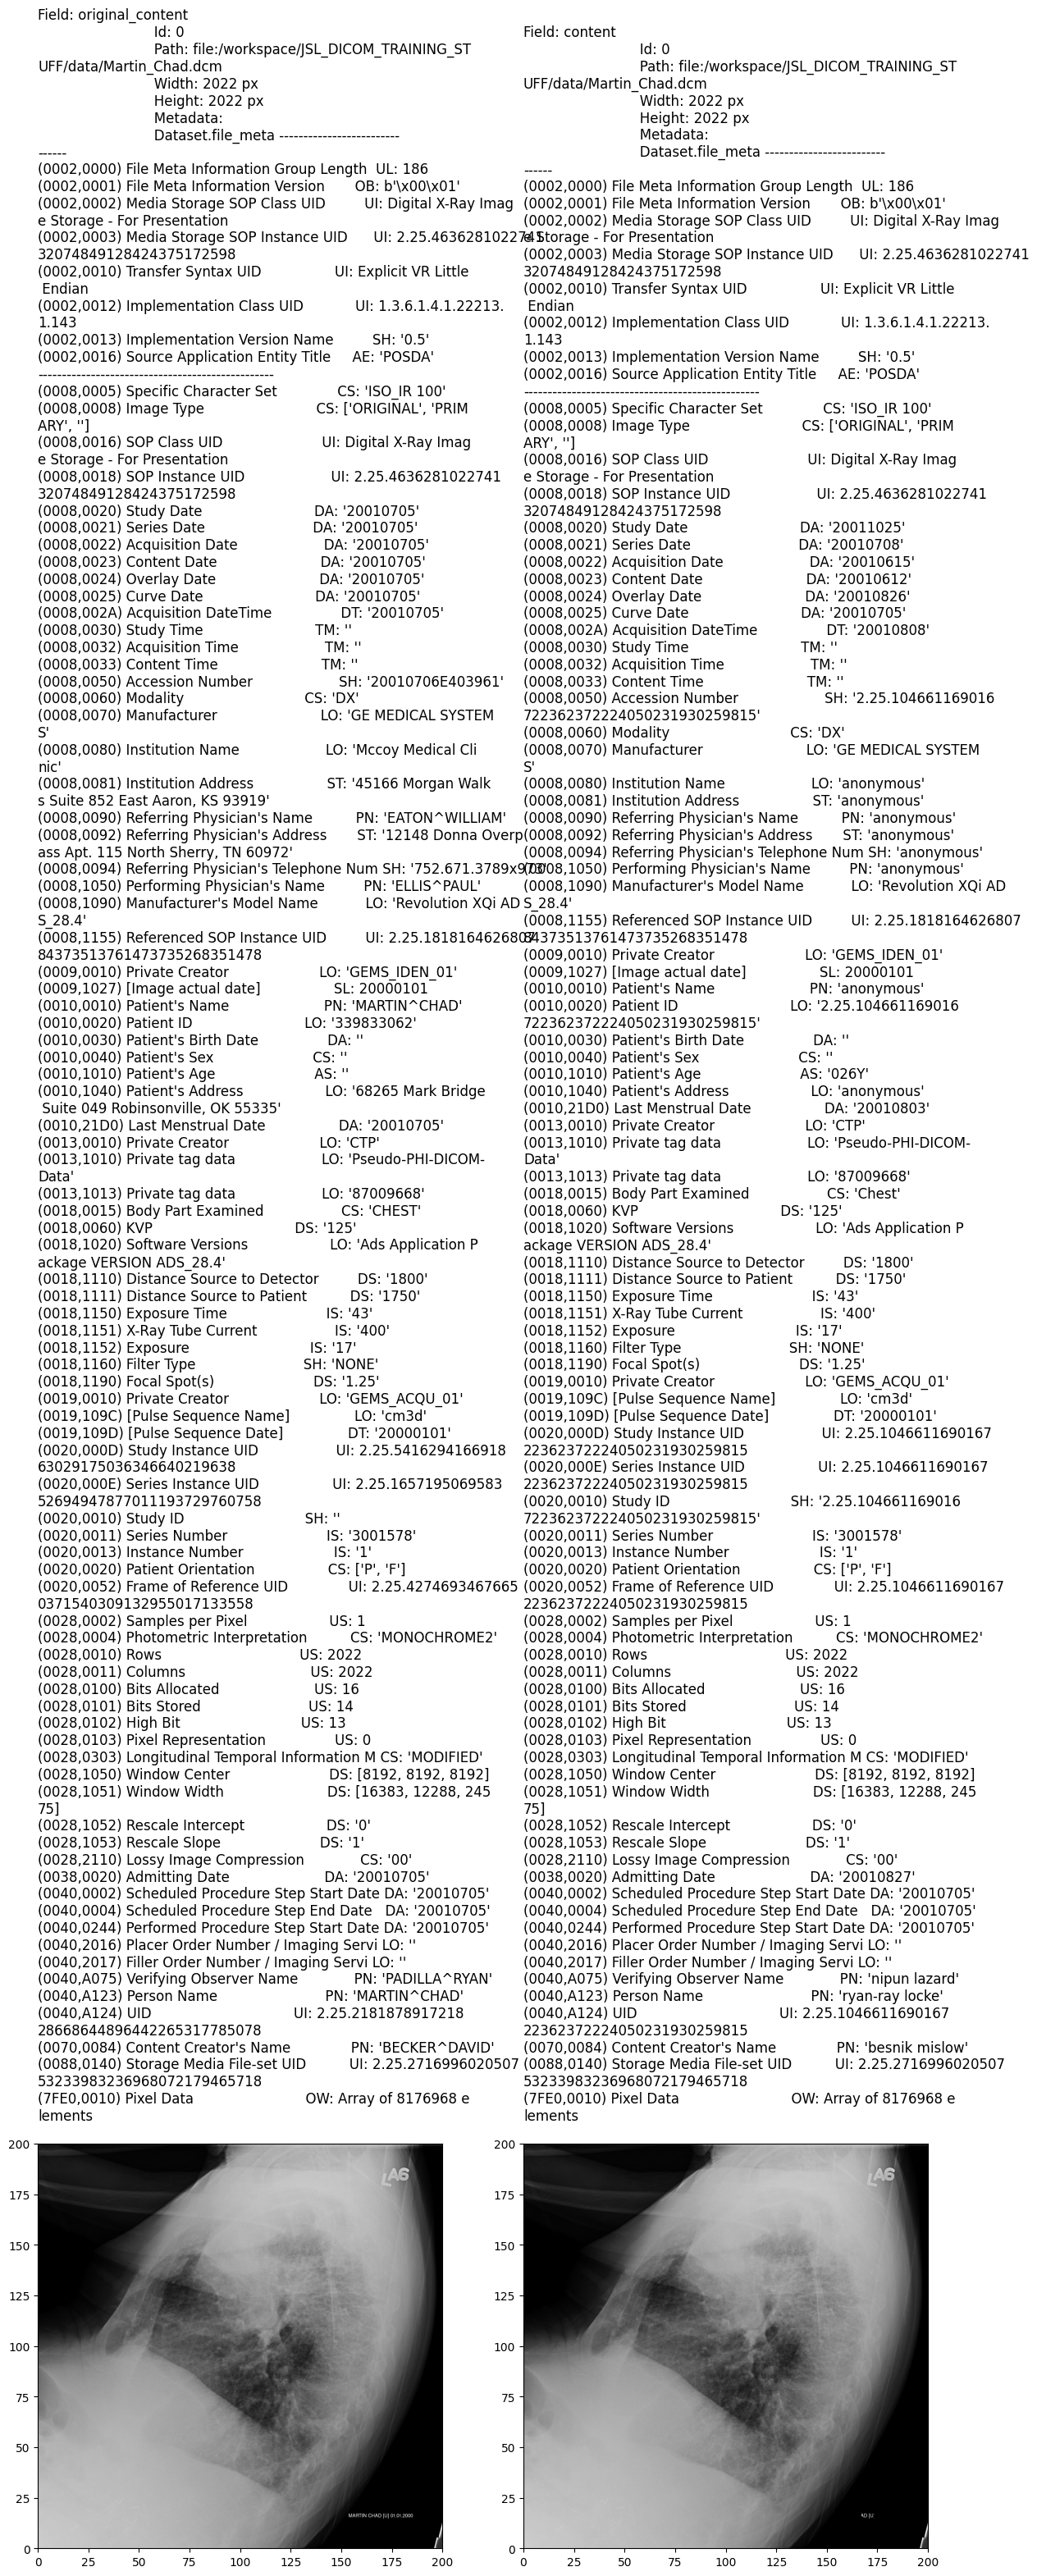

In [17]:
df = spark.read.format("binaryFile").load("./data/result/martin_chad/*.dcm").select("content")

df_orig = spark.read.format("binaryFile").load("./data/Martin_Chad.dcm").withColumnRenamed("content","original_content")

display_dicom(df.join(df_orig), "original_content,content")

<h2>Example 3: Deidentifying Good Guy's DICOM Image</h2>

<p><strong>Input DICOM File Path:</strong> <code>./data/Good_Guy.dcm</code></p>

<p><strong>Number of Frames in Input:</strong> 1</p>

<p><strong>Output Deidentified DICOM File Path:</strong> <code>./data/result/good_guy/</code></p>

In [18]:
df = spark.read.format("binaryFile").load("./data/Good_Guy.dcm")

dicom_full_pipe.fit(df).transform(df).write \
  .format("binaryFormat") \
  .option("type", "dicom") \
  .option("field", "dicom_meta_cleaned") \
  .option("nameField", "fileName") \
  .option("extension", "dcm") \
  .option("prefix", "de-id-") \
  .mode("overwrite") \
  .save("./data/result/good_guy/")

25/04/08 13:34:35 WARN SparkContext: The path /root/.local/lib/python3.11/site-packages/sparkocr/resources/ocr/dicom/first_names.all.txt has been added already. Overwriting of added paths is not supported in the current version.
25/04/08 13:34:35 WARN SparkContext: The path /root/.local/lib/python3.11/site-packages/sparkocr/resources/ocr/dicom/last_names.all.txt has been added already. Overwriting of added paths is not supported in the current version.
25/04/08 13:34:36 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
13:34:36, INFO Run DicomToImageV3
13:34:36, INFO DicomToImageV3: Number of frames: 1
25/04/08 13:35:02 WARN DAGScheduler: Broadcasting large task binary with size 1295.5 KiB
13:35:02, INFO DicomDrawRegions: file:/workspace/JSL_DICOM_TRAINING_STUFF/data/Good_Guy.dcm Origin size: 901038
13:35:02, INFO DicomDrawRegions: file:/workspace/JSL_DICOM_TRAINING_STUFF/data/Good_Guy.dcm Photometric Interpretation: MONOCHROME2
13:35:02, INFO DicomDrawRegions: file:/

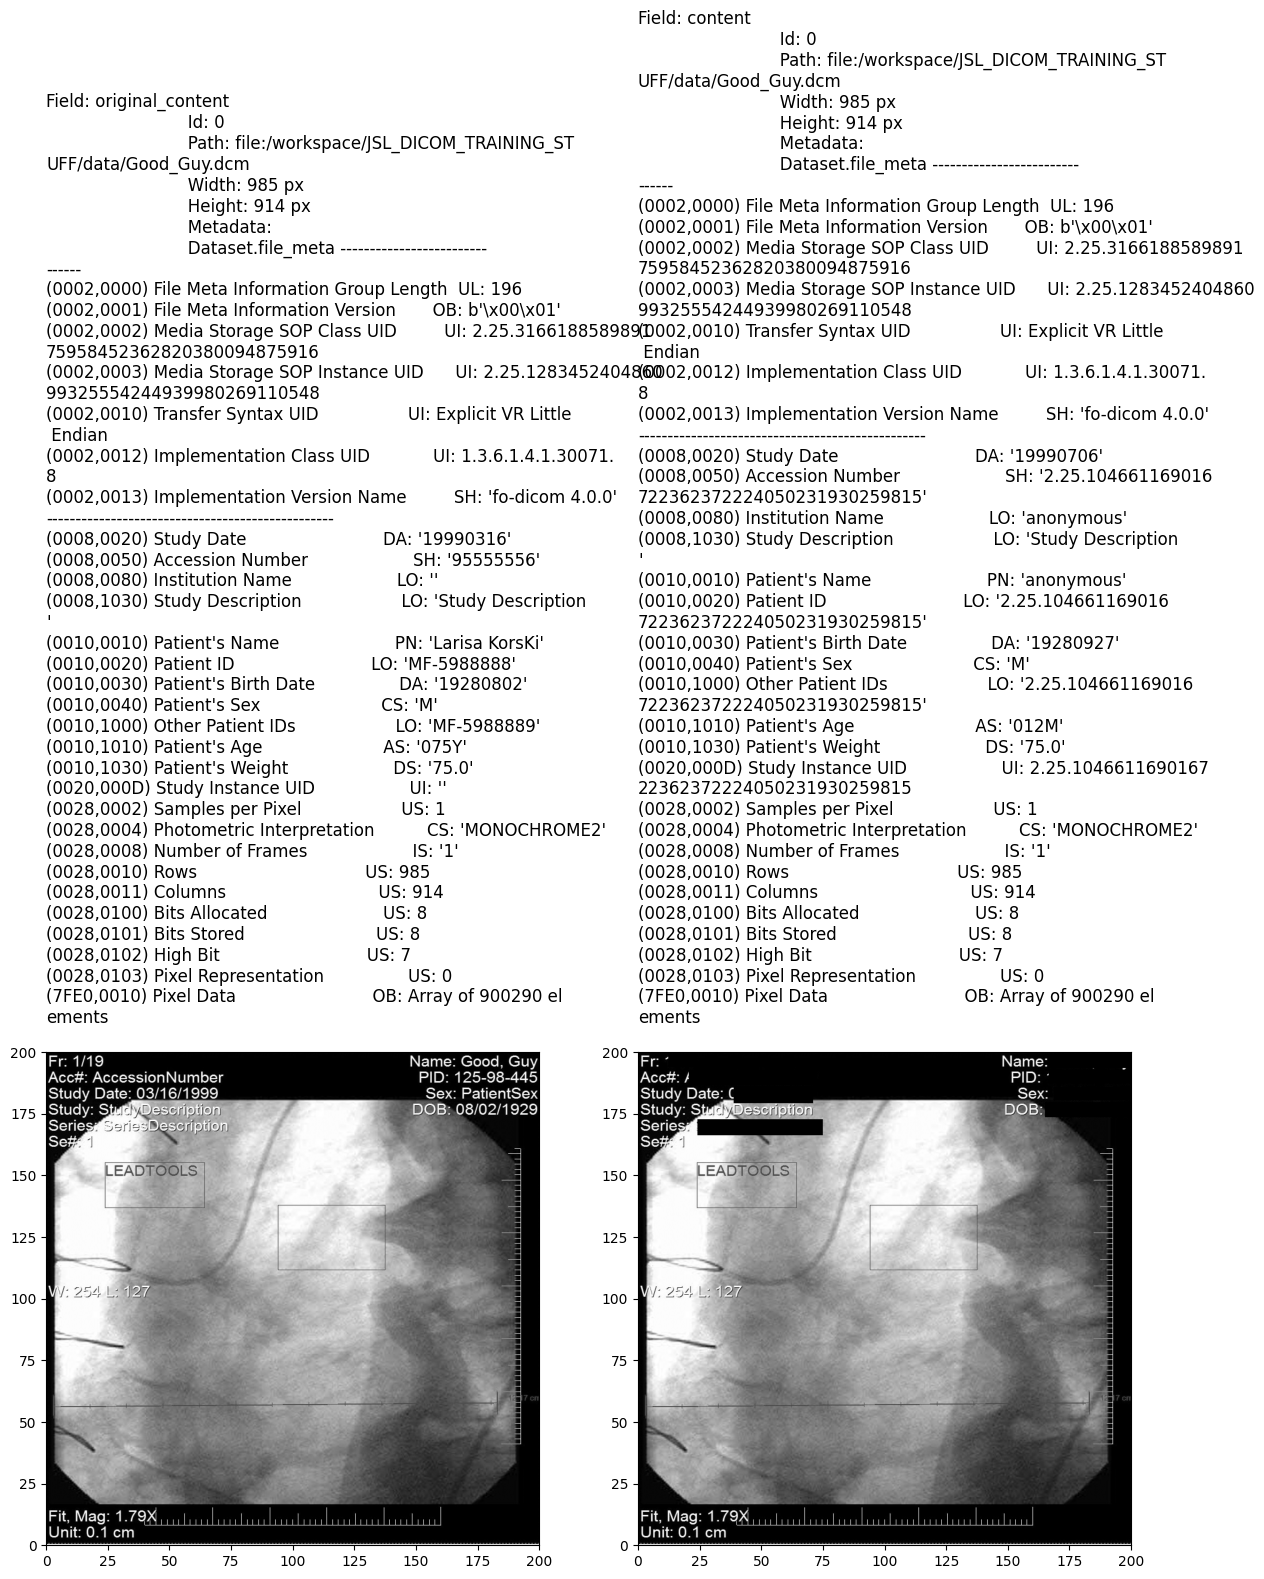

In [19]:
df = spark.read.format("binaryFile").load("./data/result/good_guy/*.dcm").select("content")

df_orig = spark.read.format("binaryFile").load("./data/Good_Guy.dcm").withColumnRenamed("content","original_content")

display_dicom(df.join(df_orig), "original_content,content")

<h2>Example 4: Deidentifying John Stiles DICOM Image</h2>

<p><strong>Input DICOM File Path:</strong> <code>./data/John_Stiles.dcm</code></p>

<p><strong>Number of Frames in Input:</strong> 1</p>

<p><strong>Output Deidentified DICOM File Path:</strong> <code>./data/result/john_stiles/</code></p>

In [20]:
df = spark.read.format("binaryFile").load("./data/John_Stiles.dcm")

dicom_full_pipe.fit(df).transform(df).write \
  .format("binaryFormat") \
  .option("type", "dicom") \
  .option("field", "dicom_meta_cleaned") \
  .option("nameField", "fileName") \
  .option("extension", "dcm") \
  .option("prefix", "de-id-") \
  .mode("overwrite") \
  .save("./data/result/john_stiles/")

25/04/08 13:35:04 WARN SparkContext: The path /root/.local/lib/python3.11/site-packages/sparkocr/resources/ocr/dicom/first_names.all.txt has been added already. Overwriting of added paths is not supported in the current version.
25/04/08 13:35:04 WARN SparkContext: The path /root/.local/lib/python3.11/site-packages/sparkocr/resources/ocr/dicom/last_names.all.txt has been added already. Overwriting of added paths is not supported in the current version.
25/04/08 13:35:05 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
13:35:05, INFO Run DicomToImageV3
13:35:05, INFO DicomToImageV3: Number of frames: 1
25/04/08 13:35:28 WARN DAGScheduler: Broadcasting large task binary with size 1295.5 KiB
13:35:28, INFO DicomDrawRegions: file:/workspace/JSL_DICOM_TRAINING_STUFF/data/John_Stiles.dcm Origin size: 640688
13:35:28, INFO DicomDrawRegions: file:/workspace/JSL_DICOM_TRAINING_STUFF/data/John_Stiles.dcm Photometric Interpretation: MONOCHROME2
13:35:28, INFO DicomDrawRegions: 

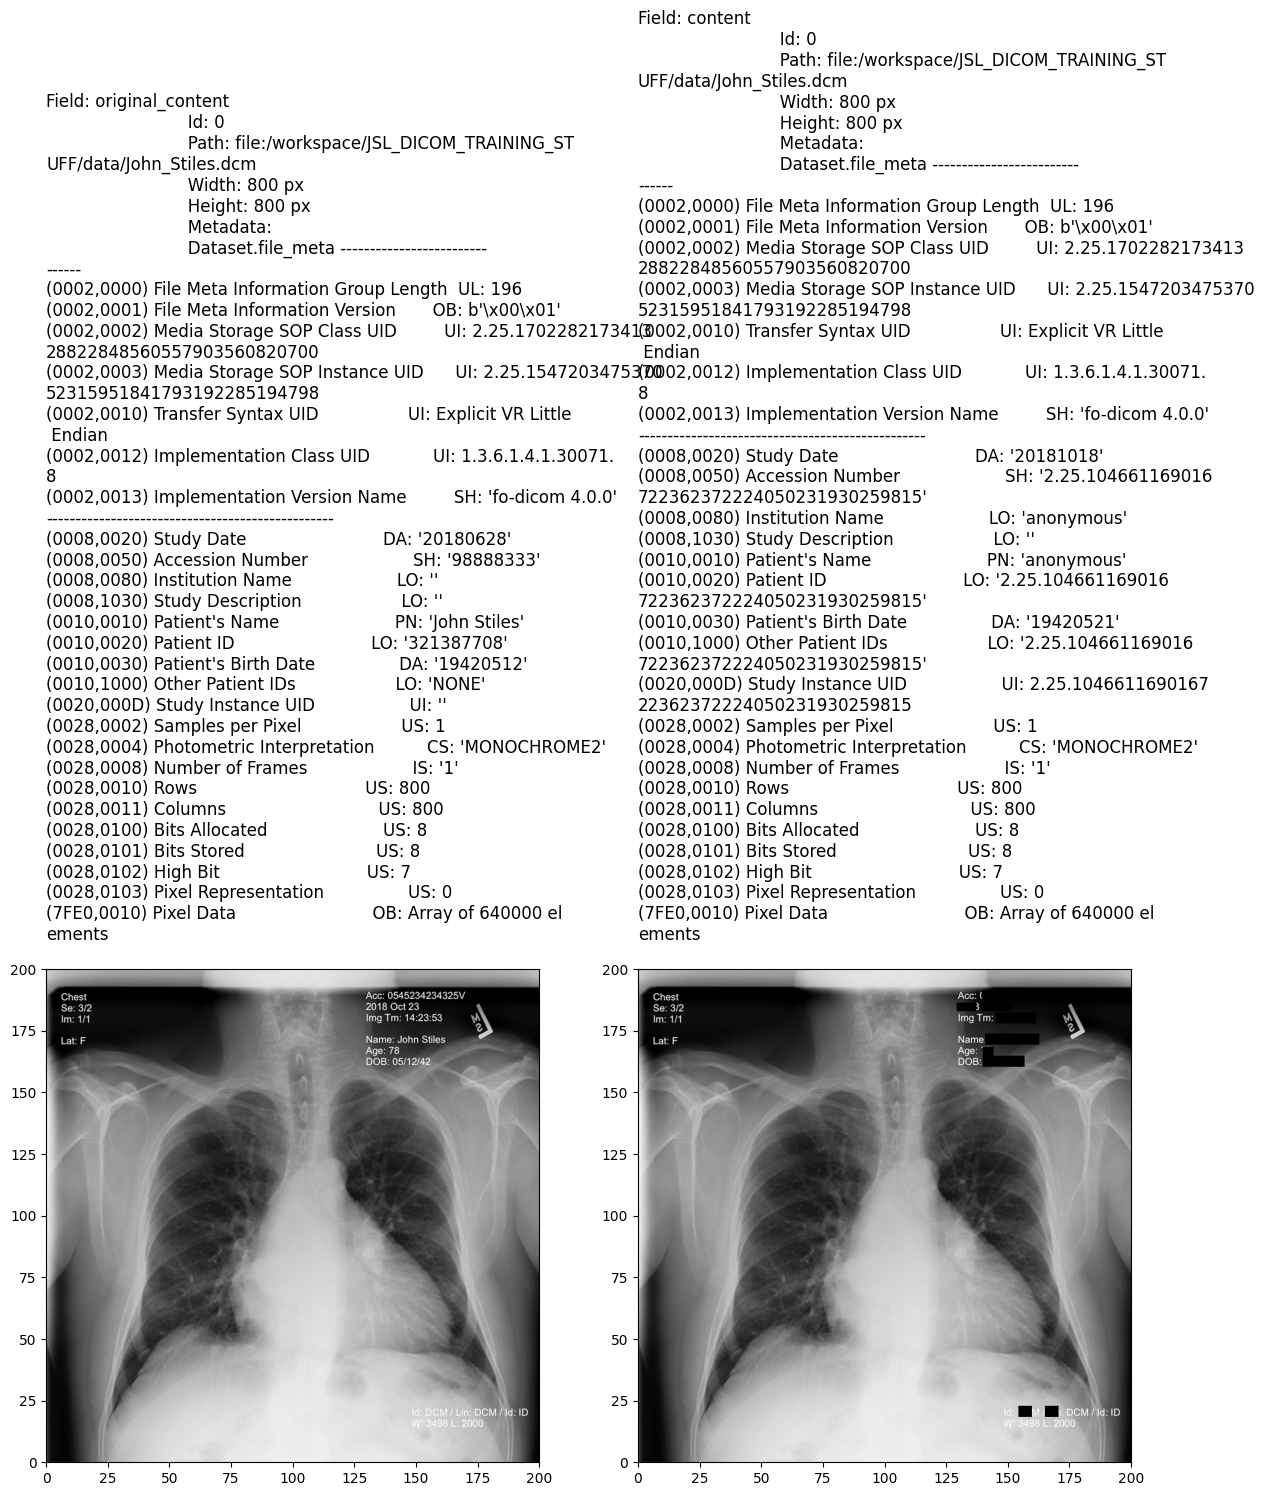

In [21]:
df = spark.read.format("binaryFile").load("./data/result/john_stiles/*.dcm").select("content")

df_orig = spark.read.format("binaryFile").load("./data/John_Stiles.dcm").withColumnRenamed("content","original_content")

display_dicom(df.join(df_orig), "original_content,content")